# Content

In this lecture I will introduce:
- The programming language Julia
- Using Jupyter notebooks to run computations and present them
- How to compute the orbit of a (deterministic and random) dynamical system in Julia
- How to compute Birkhoff averages
- Automatic differentiation
- Classical algorithm to approximate Lyapunov exponent (non-rigorous)
- How to make animations to show the Central Limit Theorem in action

# Introduction to Julia and Jupyter

In this notebook I will introduce Julia notation and some of its characteristics, so that it is easy for you to follow the next lectures.
The first thing to stress is that Julia is a language with a different approach than 
1. C, C++, Fortran: if possible Julia infers the type of the variables from the context, so code can be written in a generic way and Julia takes care of the details (most of the time)
2. Python: in Python the code is interpreted, so it runs slowly. Julia does the following, once the types are identified Julia compiles the code. So the first run of a program is slow, but all subsequent runs are fast.

We will see this through examples.

But, first, I will introduce some of the commands of Jupyter notebooks. Jupyter notebooks consists of cells, of essentially two types: 
- Markdown cells, where text can be written, 
- Code cells where code is written and run.

You can create a new cell above the selected one by pressing __a__ and below the selected one by pressing __b__ . If you select a cell and press __dd__ this will delete the cell. 

You can edit a cell by pressing __ENTER__ when it is selected and you run the code (or compile the Markdown) in a cell by pressing __SHIFT+ENTER__.
Remark that when you select a Markdown cell and press enter, you 

The key __ESC__ will take you to navigation mode, a mode that allows you to move with your arrows between cells.

By default, new cells are Code cells, if you want to turn a code into Markdown, you enter navigation mode, select the cell and press __m__. To change a Markdown cell to code, enter navigation mode, select the cell and press __y__.

In Markdown cells it is possible to write LaTeX code, as 
$$\frac{1}{N-1}\sum_{i=0}^{N-1}\phi(T^i(x_0))$$
and it is possible to use Markdown syntax, that allows to typeset in a similar way as HTML (while being much simpler).
A good reference for Markdown syntax is 
__[DataCamp Markdown tutorial](https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=aud-390929969673:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1001655&gclid=Cj0KCQjwjo2JBhCRARIsAFG667V_O7vei8Tvaa0wRyoIgzbUrKtpHLpPVKBPYlXIMr5p4b5YxTvuXZwaApHUEALw_wcB)__.

#### Exercise 1
Create a cell below this one and convert it to a Markdown cell. Make an unordered list with three items: 
- one equation, my favourite is $e^{2\pi i x}-1=0$
- the name of a theorem, my favourite is Birkhoff Ergodic Theorem
- your country of origin, I'm italian but I now live in Brazil.

Now we can start speaking about Julia.
First of all: a line starting with __#__ is a comment.

### Julia: Variable declaration

In [87]:
# This is a code cell

x = 1   #interpreted as an integer
println(x)
println(typeof(x))

1
Int64


In [88]:
y = 1.0   #interpreted as an Float64 (corresponding to double in C)
println(x)
println(typeof(x))

1
Int64


In [89]:
z = x+y # Julia automatically promotes the Int64 type to a Float64 type, to make sense of this operation
println(z)
println(typeof(z))

2.0
Float64


In [90]:
# we can also create variables with explicit types
x = BigFloat("1.0") # these are MPFR high precision numbers
println(x)
println(typeof(x))
println(precision(x)) #get the precision in bit of the mantissa of x

1.0
BigFloat
1024


If needed, the documentation is obtained by prepending a ? to the name of a function: we are interested in the function setprecision

In [170]:
?setprecision

search: setprecision



```
setprecision([T=BigFloat,] precision::Int)
```

Set the precision (in bits) to be used for `T` arithmetic.

!!! warning
    This function is not thread-safe. It will affect code running on all threads, but its behavior is undefined if called concurrently with computations that use the setting.


---

```
setprecision(f::Function, [T=BigFloat,] precision::Integer)
```

Change the `T` arithmetic precision (in bits) for the duration of `f`. It is logically equivalent to:

```
old = precision(BigFloat)
setprecision(BigFloat, precision)
f()
setprecision(BigFloat, old)
```

Often used as `setprecision(T, precision) do ... end`

Note: `nextfloat()`, `prevfloat()` do not use the precision mentioned by `setprecision`


In [92]:
setprecision(BigFloat, 1024) # if you run a cell, the output of the last line is given by the cell

1024

In [93]:
y = BigFloat("1.0") # these are MPFR high precision numbers
println(y)
println(typeof(y))
println(precision(y)) #get the precision in bit of the mantissa of x

1.0
BigFloat
1024


In [94]:
z = x+y
precision(z) 
# the output of the last line is given by the cell, here Julia took care of promoting the type 
# to guarantee no precision loss

1024

In [95]:
x = Float64(π) # to write π, I wrote \pi and pressed the tab key; using this Unicode character
#tells Julia to compute the constant adequate for the type precision

3.141592653589793

#### Exercise 2:
Create two variables x and y, of type Float64 and type BigFloat respectively, both with value $\pi$.
Compute x-y.

### Installing packages and plotting

Before going forward, we would like to install the plotting package for Julia. This can be done in two different ways. Either you go back to the command line, press ] and in the pkg prompt you launch the command "add Plots", or we make visible the Pkg package in our working namespace and use it here. 

Installing a package is something that is needed to be only once for each environment you are using. 
Julia has an environment system, that allows you to have different installed packages and different versions of the packages for different jobs... I will not enter into details here, but it is good to know that we are working in the main julia environment at the moment and there is the possibility of having different environments through the use of the command __activate__.

The following two cells are going to be run only once during the course.

In [12]:
using Pkg # this brings Pkg into our working environment

In [13]:
Pkg.add("Plots") # this installs Plots in the active environment

    Updating registry at `~/.julia/registries/General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


### Function declaration

In [23]:
# A function can be declared in different ways

# One line declaration
f(x) = 4*x*(1-x)

f (generic function with 1 method)

We will see now the behaviour of the Just in Time compiler of Julia. The first time we will run the function the function is going to be slow, due to compilation time, the second time it is going to be fast because the function is already compiled. Please remark that each time we change the type of the variables Julia is going to compile a new version.

Another thing worth nothing are macros, that begin with __@__. Macros act on the source code of Julia to change it before compilation. The __@time__ macro can be used in front of a function to have a simple benchmark of its behaviour.

In [24]:
x = BigFloat(π)/4
@time f(x)

  0.004314 seconds (929 allocations: 60.065 KiB, 98.97% compilation time)


0.6741915533174535837540206333104651003687445475649081643716072482528052006814076878775914744124790100261416080697765206276507575790430705498227049886321817022026841386502946134626831343147388727351646262364754344310168032487145135499713383118161373440002252137945623365329996083307051245405924730515360067109872

As you can see, the output shows the fact that most of the time was spent compiling the function.

In [25]:
@time f(x)

  0.000013 seconds (6 allocations: 624 bytes)


0.6741915533174535837540206333104651003687445475649081643716072482528052006814076878775914744124790100261416080697765206276507575790430705498227049886321817022026841386502946134626831343147388727351646262364754344310168032487145135499713383118161373440002252137945623365329996083307051245405924730515360067109872

Once the function is compiled, the computation time radically decreases.

Now, we will bring Plots into the namespace, to plot our function. Plots is a big package, and the first time it runs it is going to be slow. This is one of the main issues with Julia, and the time to first plot is a benchmark for new versions of Julia.

In [26]:
using Plots # this brings the plot package into our namespace

  0.002719 seconds (4.44 k allocations: 168.133 KiB)


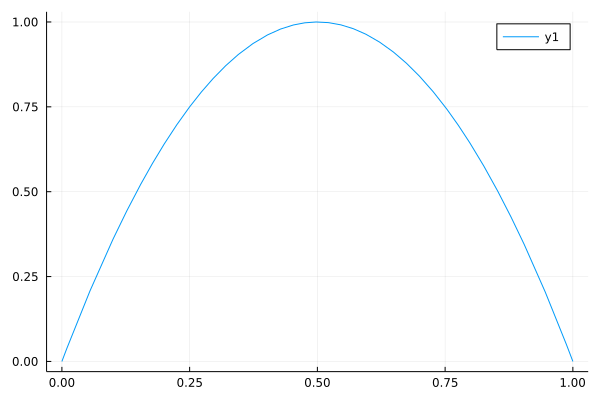

In [96]:
@time plot(f, 0, 1)

The second time, again is much faster.

  0.001302 seconds (4.44 k allocations: 168.133 KiB)


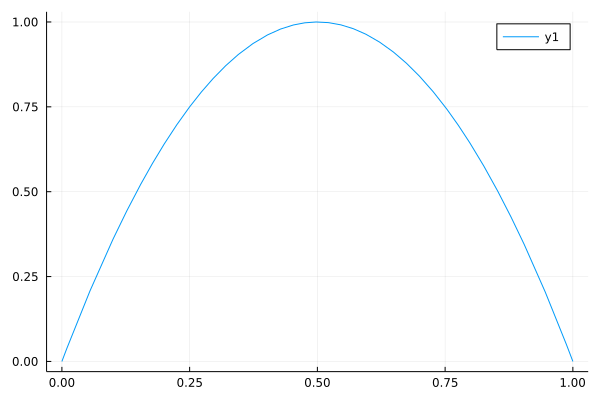

In [97]:
@time plot(f, 0, 1)

Multiline functions can be declared by using the following syntax.

In [99]:
function orbit(f, x, n)
    v = Array{typeof(x), 1}(undef, n) #this declares an uninitialized vector
    v[1] = x
    for i in 2:n
        x = f(x)
        v[i] = x
    end
    return v
end

orbit (generic function with 1 method)

This function computes the orbit $x, f(x), \ldots, f^{n-1}(x)$ for any point $x$. We compute an orbit of length $100$ for the point $x=0.1$.

In [100]:
v100 = orbit(f, 0.1, 100)

100-element Vector{Float64}:
 0.1
 0.36000000000000004
 0.9216
 0.28901376000000006
 0.8219392261226498
 0.5854205387341974
 0.970813326249438
 0.11333924730376121
 0.4019738492975123
 0.9615634951138128
 0.1478365599132853
 0.5039236458651636
 0.9999384200124991
 ⋮
 0.9545172316980255
 0.17365634435825364
 0.5739992736895251
 0.9780964299736911
 0.08569521458564608
 0.3134061791310646
 0.8607309840541266
 0.4794926285733658
 0.9983177908686801
 0.0067175172150335735
 0.026689568709997204
 0.10390894252828617

The following is a Time Series plot of the orbit of the point $0.1$ under the action of the dynamics, similar to the one Prof. Sato showed you in his introduction.

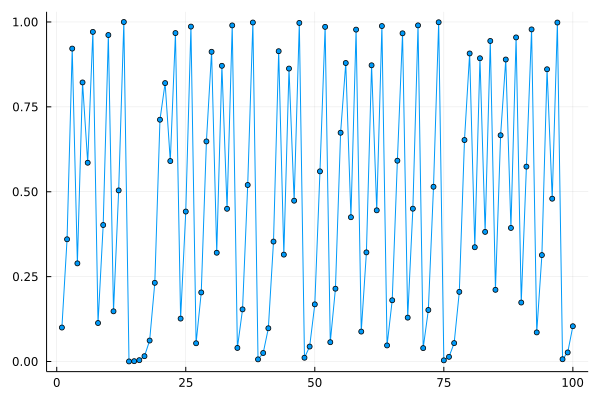

In [101]:
plot(v100, markershape = :circle, markersize = 3, label = "")

A couple of remarks about Duck Typing. The code I wrote above is generic; indeed, if I change the type of the x point, the code will run again, but with a different type. Here I compute the orbit of the same point, but using higher precision Floating Point numbers, that Julia calls BigFloats and rely on the MPFR library.

In [103]:
v2000 = orbit(f, BigFloat("0.1"), 2000)

2000-element Vector{BigFloat}:
 0.1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000001
 0.3599999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999986
 0.921599999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999999993
 0.2890137600000000000000000

The following is an histogram plot for the distribution of first $2000$ iterates of the orbit of the point $0.1$
under the action of the dynamic, compared to the invariant density of the map, which is known explictly 
to be
$$
f(x)=\frac{1}{\pi\sqrt{x(1-x)}}
$$

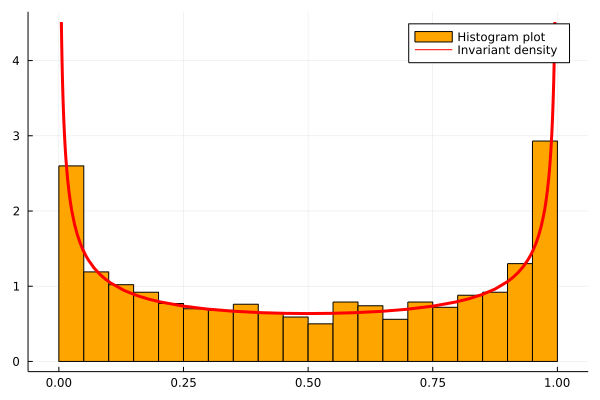

In [104]:
histogram(v2000, bins = 20, normalize = true, label = "Histogram plot", color = :orange)
plot!(x-> 1/(π*sqrt(x*(1-x))), color = :red, 0.005 , 0.995, linewidth = 3, label = "Invariant density" )

Let's take a closer look to how I implemented the code; the important line is the following

```v = Array{typeof(x), 1}(undef, n)```

the Array type is a classical array, as we usually see in C, C++, Fortran.
This is a parametric type and what is written inside __{__ and __}__ are the parameters of this type.
This is going to be an array of elements which have the same type as $x$ of dimension 1.

Inside __(__ and __)__ are the arguments of the function:
- undef tells us tha the Array is going to be uninitialized
- n is the length of the array

In [106]:
z = Array{Int64, 1}(undef, 10) #remark that it is uninitialized, so it contains garbage!!! Be careful!

10-element Vector{Int64}:
 139999291287120
 140000713080208
 139998544908720
 139998579046800
 139998579046864
 139998579046896
 139998588888512
               0
               0
               0

In [107]:
z = zeros(Int64, 10) # initializes the array to 0

10-element Vector{Int64}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [109]:
z = ones(Int64, 10) # initializes the array to 1

10-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

If we want to initalize and array to a specific value, we use the function fill. I will print on screen the documentation thorugh the use of Julia help.

In [110]:
?fill

search: fill fill! finally findall filter filter! filesize filemode isfile



```
fill(x, dims::Tuple)
fill(x, dims...)
```

Create an array filled with the value `x`. For example, `fill(1.0, (5,5))` returns a 5×5 array of floats, with each element initialized to `1.0`.

`dims` may be specified as either a tuple or a sequence of arguments. For example, the common idiom `fill(x)` creates a zero-dimensional array containing the single value `x`.

# Examples

```jldoctest
julia> fill(1.0, (2,3))
2×3 Matrix{Float64}:
 1.0  1.0  1.0
 1.0  1.0  1.0

julia> fill(42)
0-dimensional Array{Int64, 0}:
42
```

If `x` is an object reference, all elements will refer to the same object:

```jldoctest
julia> A = fill(zeros(2), 2);

julia> A[1][1] = 42; # modifies both A[1][1] and A[2][1]

julia> A
2-element Vector{Vector{Float64}}:
 [42.0, 0.0]
 [42.0, 0.0]
```


In [111]:
fill(3, 10) # this one fills an array with the first argument, the type of the Array is inferred from the value

10-element Vector{Int64}:
 3
 3
 3
 3
 3
 3
 3
 3
 3
 3

As you can see, this allows us for a lot of flexibility in writing code. My code above also works for Rational numbers.

In [112]:
1//7 #this is the rational 1/7

1//7

In [115]:
orbit(f, 1//10, 5) # we don't take an orbit of length 10 because it gives an overflow in Int64

5-element Vector{Rational{Int64}}:
            1//10
            9//25
          576//625
       112896//390625
 125417972736//152587890625

In [117]:
orbit(f, BigInt(1)//BigInt(10), 10)

10-element Vector{Rational{BigInt}}:
                                                                                                                                                                                                                                                                                                                                                                      1//10
                                                                                                                                                                                                                                                                                                                                                                      9//25
                                                                                                                                                                                                                                           

If you look back at all the examples in which we computed the orbit, the output contains the type of the elements of the array.

In the last one, the output is of type:
```10-element Vector{Rational{BigInt}}:```

Another interesting possibility is the possibility of vectorizing the functions, using the __.__ before the arguments of the functions.

In [118]:
x = rand(10) # I take 10 random initial points
orbit.(f, x, 10) # this is going to compute the orbits for these ten points

10-element Vector{Vector{Float64}}:
 [0.2477746599629247, 0.7455295113727269, 0.7588610361802798, 0.7319638557906876, 0.7847710784268684, 0.6756217315663934, 0.8766280296064867, 0.4326053092589416, 0.9818318226396684, 0.07135237876694056]
 [0.8982007676087111, 0.36574459470333287, 0.9279019445945106, 0.26759970324894555, 0.7839604082800873, 0.6774659461176246, 0.8740233518743055, 0.44042612901083794, 0.9858038155814666, 0.05597861106595368]
 [0.6397218460553504, 0.9219112229395399, 0.2879636798306476, 0.8201623957161596, 0.589984161477157, 0.9676114027330117, 0.12535830413626048, 0.4385743988813652, 0.9849075821088574, 0.05945854725336677]
 [0.10570828508117902, 0.37813617418550083, 0.9405968318314136, 0.22349772712048407, 0.6941859723698468, 0.8491672325391084, 0.5123289748839207, 0.9993919855132466, 0.0024305792205492134, 0.00969868602080739]
 [0.5782548236230838, 0.9755047303188802, 0.09558100577747611, 0.3457811084481688, 0.9048661339540981, 0.3443336543082492, 0.9030719552759054, 

Suppose now that we want to write a specialized version of the orbit function that returns, instead of an array of arrays a matrix, when we feed it a vector of initial conditions.

To do so, we specialize one of the arguments, i.e., we tell to the compiler that when x is of type 
```Vector{Float64}``` (which is the same as ```Array{Float64, 1}```) we want this specific version of the function orbit to be run.

In [119]:
function orbit(f, x::Vector{Float64}, n)
    k = length(x)
    v = Array{Float64, 2}(undef, (n, k)) 
    v[1, :] = x
    for i in 2:n
        x = f.(x)
        v[i, :] = x
    end
    return v
end

orbit (generic function with 2 methods)

In [33]:
orbit(f, rand(10), 10)

10×10 Matrix{Float64}:
 0.208624  0.915749     0.314637   …  0.443663   0.184515   0.457355
 0.660401  0.30861      0.862563      0.987304   0.601876   0.992726
 0.897087  0.85348      0.474193      0.0501377  0.958485   0.0288857
 0.369289  0.500208     0.997336      0.190496   0.159165   0.112205
 0.931658  1.0          0.0106276     0.616828   0.535325   0.398462
 0.254685  6.89436e-7   0.0420586  …  0.945405   0.995009   0.95876
 0.759281  2.75774e-6   0.161159      0.206459   0.0198659  0.158158
 0.731093  1.10309e-5   0.540746      0.655334   0.0778849  0.532576
 0.786385  4.41233e-5   0.993359      0.903486   0.287276   0.995755
 0.671936  0.000176485  0.0263879     0.348797   0.818993   0.016907

In [120]:
v = orbit(f, rand(1000), 200); #the semicomma disables the output

The following animation shows how $1000$ uniformly distributed initial points distribute themselves under iteration of the map $f$. Doing animations is quite simple, what we do is to make a for cycle that generates plots, and use a Julia macro to decorate the code.

In [123]:
?animate

search: animate @animate Animation



Animate from an iterator which returns the plot args each iteration.


┌ Info: Saved animation to 
│   fn = /home/isaia/WorkingFolder/HokkaidoSchool/tutorial_anim_fps30.gif
└ @ Plots /home/isaia/.julia/packages/Plots/Di0Qb/src/animation.jl:114


Plots.AnimatedGif("/home/isaia/WorkingFolder/HokkaidoSchool/tutorial_anim_fps30.gif")
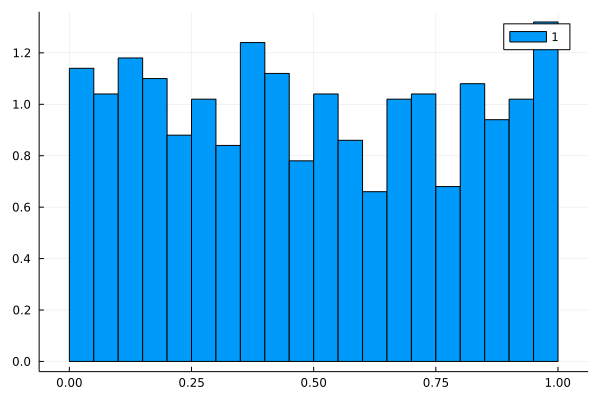

In [124]:
anim =  @animate for i in 1:200
    histogram(v[i, :], bins = 40, label = "$i", normalize = true)
end 
gif(anim, "tutorial_anim_fps30.gif", fps = 5)

The next issue is how we can make the function orbit for a vector more generic. To do so we will use parametric functions. The function will depend from a parameter, that has to be known at compile time, as the type of the element of our Vector, or the number of its indices (called its dimension).

In [131]:
function orbit(f, x::Vector{T}, n) where {T} # this where T means that this is a parametric type
    k = length(x)
    v = Array{T, 2}(undef, (n, k)) 
    v[1, :] = x
    for i in 2:n
        x = f.(x)
        v[i, :] = x
    end
    return v
end

orbit (generic function with 3 methods)

In [132]:
v = orbit(f, rand(BigFloat, 1000), 200) # now, this works, the compiler sees that the input is a vector of 
# BigFloat, so checks if there is a parametric function that he can compile, sees that T = BigFloat and
# substitutes T in the text of the function and compiles it consequently.
# After the first run, once it is compiled, it is really fast !!!

200×1000 Matrix{BigFloat}:
 0.527762   0.0169915    0.625029   …  0.406104    0.529696     0.98901
 0.996917   0.0668113    0.937471      0.964734    0.996472     0.0434764
 0.0122939  0.24939      0.234475      0.136088    0.0140602    0.166345
 0.0485709  0.748779     0.717987      0.470271    0.0554501    0.554697
 0.184847   0.752437     0.809927      0.996465    0.209502     0.988033
 0.602715   0.745103     0.615782   …  0.0140908   0.662443     0.0472957
 0.957799   0.759698     0.946378      0.0555688   0.894449     0.180235
 0.161681   0.730228     0.202985      0.209924    0.37764      0.591002
 0.54216    0.787981     0.647128      0.663423    0.940112     0.966874
 0.99289    0.668268     0.913413      0.893171    0.225207     0.128113
 0.0282377  0.886743     0.316359   …  0.381665    0.697954     0.446801
 0.109761   0.401718     0.865104      0.943987    0.843256     0.98868
 0.390855   0.961363     0.466795      0.211501    0.5287       0.0447688
 ⋮                     

┌ Info: Saved animation to 
│   fn = /home/isaia/Dropbox/HokkaidoCourse/tutorial_anim_fps30.gif
└ @ Plots /home/isaia/.julia/packages/Plots/OchXa/src/animation.jl:104


Plots.AnimatedGif("/home/isaia/Dropbox/HokkaidoCourse/tutorial_anim_fps30.gif")
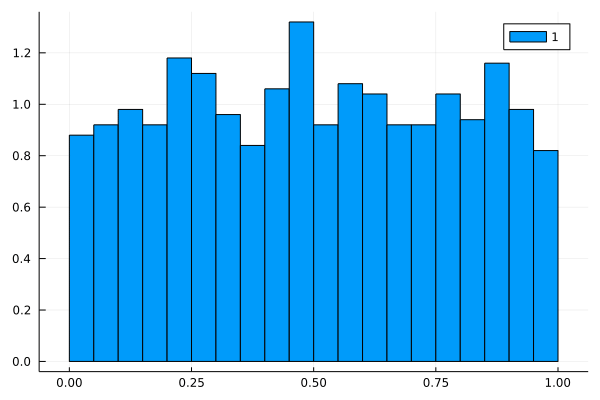

In [144]:
anim =  @animate for i in 1:200
    histogram(v[i, :], bins = 40, label = "$i", normalize = true)
end 
gif(anim, "tutorial_anim_fps30.gif", fps = 5)

#### Exercise 4 
Fill in the missing part in the following function, which is a further generalization of orbit, where we can give as an input a matrix or an $N$-index array of initial points and it returns an $N+1$-index array of orbits.
Substitute $\Omega$ for the right expression involving $N$.  

In [175]:
# this function returns a tuple of (: , :, :, :, ...) that we are going to use to access all the information
# in the multiindex below
fill_colon(N) = ntuple(x-> :, N)

function orbit(f, x::Array{T, N}, n) where {T, N} # now also N is a parameter
    k = size(x)
    v = Array{T, Ω}(undef, (n, k...)) # substitute Ω for an expression with N
    
    l = fill_colon(N) 
    v[1, l...] = x # the ... notation means we are taking the tuple and filling in as argument 2,..., N+1
                    # of the multiindex
    for i in 2:n
        x = f.(x)
        v[i, l...] = x
    end
    return v
end

orbit (generic function with 5 methods)

Now test it here!

In [35]:
orbit(f, rand(BigFloat, (10, 10)), 20)

LoadError: MethodError: no method matching -(::Int64, ::Matrix{BigFloat})
For element-wise subtraction, use broadcasting with dot syntax: scalar .- array
[0mClosest candidates are:
[0m  -(::Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8}) at int.jl:85
[0m  -(::T, [91m::T[39m) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} at int.jl:86
[0m  -(::Union{Int16, Int32, Int64, Int8}, [91m::BigInt[39m) at gmp.jl:536
[0m  ...

### Structures and types in Julia

It is possible to declare composite types in Julia. 

In [177]:
struct WorldCoordinate
    latitude
    longitude
    timezone
end

In [178]:
RJ = WorldCoordinate(-22.9, -43.19, "GMT-3")

WorldCoordinate(-22.9, -43.19, "GMT-3")

In [180]:
RJ.latitude # remark that pressing tab you get autocompletion

-22.9

In [181]:
RJ.timezone

"GMT-3"

Suppose now that we know how to compute a timezone from coordinates (without worrying about the real timezone lines, which are complicated and daylight saving time).

In [183]:
180/12

15.0

In [188]:
function timezone(latitude, longitude)  
    val = Int64(floor(longitude/15))
    if val<0
        val = abs(val)
        return "GMT-$val" #the $ symbol makes $val be substituted by val
    elseif val>0
        return "GMT+$val"
    else
        return "GMT-0"
    end
end

timezone (generic function with 1 method)

We can now define a new constructor for the object.

In [190]:
WorldCoordinate(a, b) = WorldCoordinate(a, b, timezone(a, b))

WorldCoordinate

In [192]:
WorldCoordinate(-22, -43) #this returns the object as above, but computes some of its attributes automatically

WorldCoordinate(-22, -43, "GMT-3")

### Numerical experiments in ergodic theory

We change the dynamic now into something uniformly expanding.

In [126]:
g(x) = mod(2*x+0.1*sin(2*pi*x), 1)

g (generic function with 1 method)

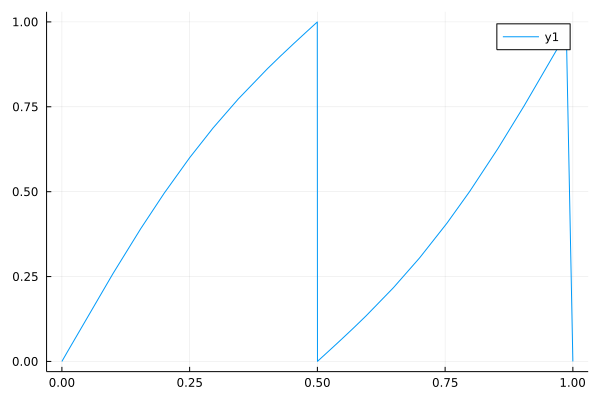

In [127]:
plot(g, 0, 1)

In [133]:
v = orbit(g, rand(BigFloat, 1000), 400)

400×1000 Matrix{BigFloat}:
 0.606946   0.63657   0.30947     …  0.364397   0.470436  0.403943
 0.151639   0.19748   0.71204        0.804056   0.959341  0.864642
 0.384782   0.489565  0.326911       0.513824   0.893411  0.654125
 0.835797   0.985682  0.742371       0.0189725  0.724747  0.225852
 0.585777   0.96238   0.384857       0.0498374  0.350749  0.550555
 0.12023    0.901342  0.835912    …  0.130479   0.782123  0.0698774
 0.309019   0.744589  0.586044       0.334062   0.466275  0.182263
 0.711242   0.389235  0.12062        0.754496   0.953582  0.455605
 0.325434   0.842583  0.309979       0.409032   0.878411  0.938744
 0.739844   0.601613  0.712941       0.872159   0.687643  0.839942
 0.379891   0.143631  0.32858     …  0.672356   0.282863  0.595433
 0.828287   0.365747  0.745217       0.256378   0.663602  0.134433
 0.56843    0.806193  0.390479       0.612675   0.24158   0.34364
 ⋮                                ⋱                       
 0.449336   0.121866  0.762407       0.9383

┌ Info: Saved animation to 
│   fn = /home/isaia/WorkingFolder/HokkaidoSchool/tutorial_anim_fps30.gif
└ @ Plots /home/isaia/.julia/packages/Plots/Di0Qb/src/animation.jl:114


Plots.AnimatedGif("/home/isaia/WorkingFolder/HokkaidoSchool/tutorial_anim_fps30.gif")
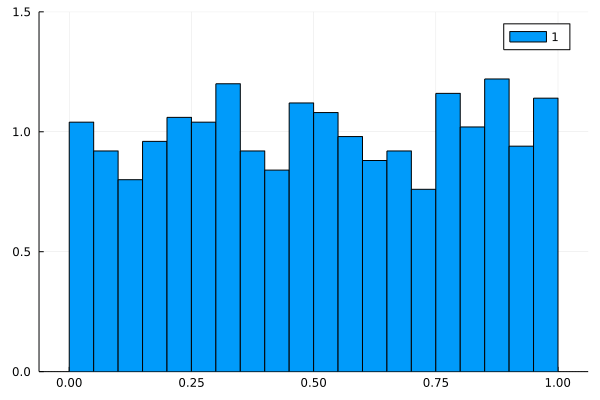

In [134]:
anim =  @animate for i in 1:400
    histogram(v[i, :], bins = 40, label = "$i", normalize = true, ylims = (0, 1.5) )
end 
gif(anim, "tutorial_anim_fps30.gif", fps = 5)

So, up to know we have a way to compute the orbits, we want to compute some Birkhoff averages of some observables.
Remark that the code I'm writing is storing a lot of objects in memory and can be made more efficient.

The empirical Birkhoff average along a orbit of length $N$ is
$$
\frac{1}{N} \sum_{i=0}^{N-1}\phi(f^i(x))
$$
we will compute the Birkhoff averages for $1000$ starting points along orbits of length $400$.

In [135]:
ϕ(x) = sin(x)+x^2 #ϕ is written by writing \phi and pressing tab

ϕ (generic function with 1 method)

In [136]:
function BirkhoffAverages(ϕ, v)
    w = ϕ.(v) # we evaluate the observables on the orbit
    k, n = size(w)
    z = accumulate(+, w; dims = 1) # this computes the accumulated sums along columns 
    t = [x for x in 1:k]
    z = z./t # we divide the first line by 1, the second by 2, the third by 3, etc...
    return z
end 

BirkhoffAverages (generic function with 1 method)

In [137]:
z = BirkhoffAverages(ϕ, v)

400×1000 Matrix{BigFloat}:
 0.938745  0.999662  0.400326  1.4091    …  0.489172  0.674585  0.556217
 0.556399  0.61743   0.780353  1.12199      0.927926  1.20687   1.03234
 0.545404  0.648259  0.662899  0.775248     0.870459  1.33038   1.03368
 0.76915   0.937498  0.803962  0.64045      0.657677  1.29483   0.843994
 0.794516  1.09934   0.747878  0.654854     0.536602  1.12919   0.84045
 0.684496  1.18222   0.863341  0.847374  …  0.471691  1.16041   0.712825
 0.643799  1.18934   0.868081  0.97762      0.467089  1.08992   0.641632
 0.708154  1.10705   0.77643   1.05892      0.565476  1.16928   0.642376
 0.676762  1.14585   0.73473   1.08631      0.565426  1.21062   0.758563
 0.73124   1.12406   0.777491  1.0425       0.661522  1.20032   0.827717
 0.711594  1.03676   0.745962  1.1013    …  0.699101  1.12384   0.835689
 0.770864  0.991314  0.786588  1.13061      0.667452  1.11822   0.778723
 0.77783   1.02057   0.76709   1.11451      0.689219  1.05509   0.753822
 ⋮                         

In [7]:
anim = @animate for i in 1:400
    histogram(z[i, :], bins = 40, label = "$i", xlims = (0.5, 1.1), ylims = (0, 10), normalize = true)
end 
gif(anim, "BirkhoffAverages.gif", fps = 5)

LoadError: LoadError: UndefVarError: @animate not defined
in expression starting at In[7]:1

This animations shows the CLT in action for uniformly expanding maps. As $N$ grows the Birkhoff averages distribute as a Gaussian with average the Birkhoff average of the observable.

### Automatic Differentiation and computing the Lyapunov exponent

The package DualNumbers permits us to compute automatically the derivatives of a function (Automatic Derivation, AD for short).

In [145]:
using Pkg;
Pkg.add("DualNumbers") # You will need to run this only once, to install the package

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [146]:
using DualNumbers # this brings the AD package into namespace

A dual number is a number that consists of two components, called value and epsilon; we can think of a dual number as the "jet" of a function, i.e.,

```Dual(0, 1.0)```

can be thought of $0+x$ in a neighborhood of $0$. 
The relation between derivatives become therefore operators between dual numbers.
$$(a+\epsilon b)+(b+\epsilon b') = a+b+\epsilon (a'+b')$$
$$(a+\epsilon a')\cdot (b+\epsilon b') = a\cdot b+\epsilon (a\cdot b'+a'\cdot  b)$$

Overloading the operators and the functions to work with Dual numbers allows us to compute automatically derivatives.

In [147]:
x  = Dual(0.1, 1.0)

0.1 + 1.0ɛ

In [148]:
sin(x)

0.09983341664682815 + 0.9950041652780258ɛ

As you can see, the epsilon part is nothing else than $\cos(0.1)=(\sin)'(0.1)$.
We will use this to define automatically $\log(|T'|)$.

In [149]:
ψ(x, h) = log(abs(h(Dual(x, 1)).epsilon))

ψ (generic function with 1 method)

We will now specialize it to our dynamic.

In [150]:
ϕ(x) = ψ(x, g)

ϕ (generic function with 1 method)

In [151]:
z = BirkhoffAverages(ϕ, v)

400×1000 Matrix{BigFloat}:
 0.410967  0.463202  0.571345  0.822436  …  0.461388  0.323887  0.393856
 0.635674  0.626647  0.593686  0.582574     0.627037  0.641221  0.637665
 0.565378  0.523438  0.574241  0.701448     0.523945  0.731923  0.590817
 0.634699  0.633923  0.600176  0.723345     0.634121  0.7095    0.627997
 0.583549  0.699073  0.565072  0.642032     0.698227  0.665107  0.570136
 0.636142  0.736035  0.611365  0.695962  …  0.729751  0.679959  0.632349
 0.627019  0.728375  0.578216  0.733869     0.699899  0.629427  0.658457
 0.625438  0.689486  0.618273  0.758624     0.700159  0.670273  0.617848
 0.615764  0.707586  0.612941  0.757142     0.665288  0.695532  0.65461
 0.621479  0.67707   0.613436  0.714759     0.687807  0.682514  0.674013
 0.604368  0.694702  0.606028  0.736052  …  0.673811  0.677428  0.648459
 0.623295  0.675049  0.612497  0.745583     0.674367  0.663981  0.667971
 0.602802  0.684374  0.59732   0.718798     0.654836  0.667492  0.65517
 ⋮                        

┌ Info: Saved animation to 
│   fn = /home/isaia/WorkingFolder/HokkaidoSchool/BirkhoffAverages.gif
└ @ Plots /home/isaia/.julia/packages/Plots/Di0Qb/src/animation.jl:114


Plots.AnimatedGif("/home/isaia/WorkingFolder/HokkaidoSchool/BirkhoffAverages.gif")
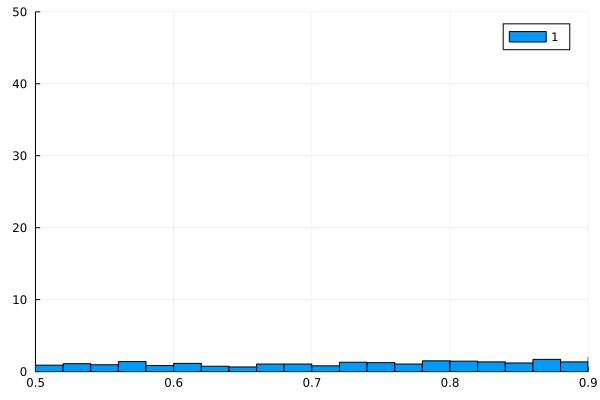

In [152]:
anim = @animate for i in 1:400
    histogram(z[i, :], bins = 40, label = "$i", xlims = (0.5, 0.9), ylims = (0, 50), normalize = true)
end 
gif(anim, "BirkhoffAverages.gif", fps = 5)

### Systems with noise

We want now do similar computations for systems with additive noise, i.e., the iterated of the system
are
$$X_i = T(X_{i-1})+\theta$$
where $\theta$ is a uniform distributed variable in $[-\xi, \xi]$.

The system we are going to study is a family of one-dimensional systems on $[-1,1]$; please note that
the noise could bring us outside $[-1, 1]$ so we need to set boundary conditions.
We will set periodic boundary conditions.
The following function applys the boundary conditions.

In [153]:
function periodic(x)    
    while x>1
        x=x-2
    end
    while x<-1
        x=x+2
    end
    return x
end

periodic (generic function with 1 method)

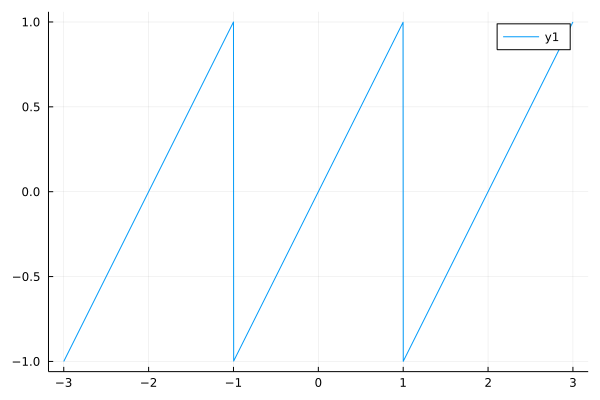

In [154]:
plot(periodic, -3, 3)

In [155]:
function orbit_with_noise(f, x::Vector{T}, ξ, n) where {T} # this where T means that this is a parametric type
    k = length(x)
    v = Array{T, 2}(undef, (n, k)) 
    
    v[1, :] = x
    for i in 2:n
        noise = ξ*(2*rand(T, k).-1.0)
        #@info sum(noise)
        x = periodic.(f.(x)+noise)
        v[i, :] = x
    end
    return v
end

orbit_with_noise (generic function with 1 method)

We will now look at a simple family of examples (introduced in [Nisoli I. - How does noise induce order](https://arxiv.org/abs/2003.08422) ) that exhibit a transition of the Lyapunov exponent from positive to negative as the noise size increases.

In [156]:
h(x) = 2*abs(x)^5-1

h (generic function with 1 method)

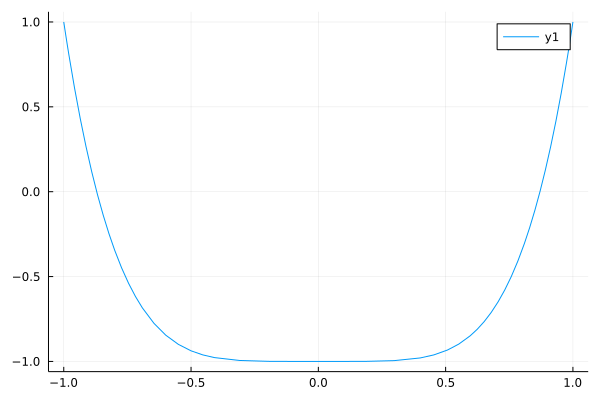

In [139]:
plot(h, -1, 1)

In [157]:
v = orbit_with_noise(h, 2*rand(Float64, 200), 0.05, 10000);

In [158]:
v

10000×200 Matrix{Float64}:
  0.902899   0.631445     1.64468   …   0.644504     0.902494   1.58114
  0.237411  -0.758818    -0.941572     -0.784662     0.189643   0.717313
 -0.977669  -0.532499     0.435126     -0.407991     0.980376  -0.60078
  0.767425  -0.877086    -0.933887     -0.97701      0.841169  -0.844803
 -0.491053  -0.00929852   0.392508      0.797558    -0.121995  -0.160136
 -0.896859   0.984869    -0.971138  …  -0.381045    -0.966193  -0.970871
  0.131011   0.856223     0.693975     -0.940816     0.681706   0.742707
 -0.993462  -0.0571098   -0.652151      0.508136    -0.671578  -0.58954
  0.917258   0.974615    -0.766051     -0.905745    -0.717164  -0.80857
  0.323247   0.784951    -0.515576      0.227261    -0.622196  -0.270196
 -0.97954   -0.392427    -0.915723  …   0.968342    -0.837286  -0.972959
  0.848861  -0.939199     0.30681       0.684359    -0.197794   0.7927
 -0.108489   0.435041     0.962553     -0.744337     0.996609  -0.389699
  ⋮                           

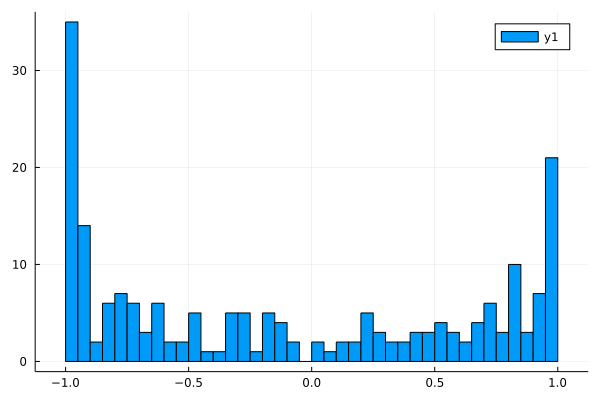

In [159]:
histogram(v[end, :], bins = 40)

In [160]:
ϕ(x) = ψ(x, h) # log(|h'|)

ϕ (generic function with 1 method)

In [161]:
z = BirkhoffAverages(ϕ, v)

10000×200 Matrix{Float64}:
  1.89401     0.463606   4.29277    …  0.545487    1.89221      4.13517
 -0.777628    0.831108   3.17727       0.939032   -1.22783      2.55439
  0.218997    0.481368   1.77622       0.198201   -0.0774495    1.79109
  0.475179    0.805523   1.83941       0.701038    0.344597     1.75031
  0.271697   -2.63739    1.18389       0.840387   -0.946828     0.395381
  0.537608   -1.82422    1.35081    …  0.440862   -0.428186     0.693541
 -0.371667   -1.32338    1.27802       0.671961   -0.257023     0.75343
 -0.0406652  -2.30152    1.19235       0.537287   -0.136134     0.682868
  0.181311   -1.80138    1.19727       0.689432   -0.0129214    0.768398
 -0.0582969  -1.48784    1.04281       0.258085    0.028829     0.398374
  0.148812   -1.4834     1.12532    …  0.43225     0.170956     0.561515
  0.273673   -1.18881    0.829583      0.461687   -0.191585     0.629167
 -0.253673   -1.17634    0.931148      0.512445   -0.000770682  0.467929
  ⋮                          

┌ Info: Saved animation to 
│   fn = /home/isaia/WorkingFolder/HokkaidoSchool/BirkhoffAverages.gif
└ @ Plots /home/isaia/.julia/packages/Plots/Di0Qb/src/animation.jl:114


Plots.AnimatedGif("/home/isaia/WorkingFolder/HokkaidoSchool/BirkhoffAverages.gif")
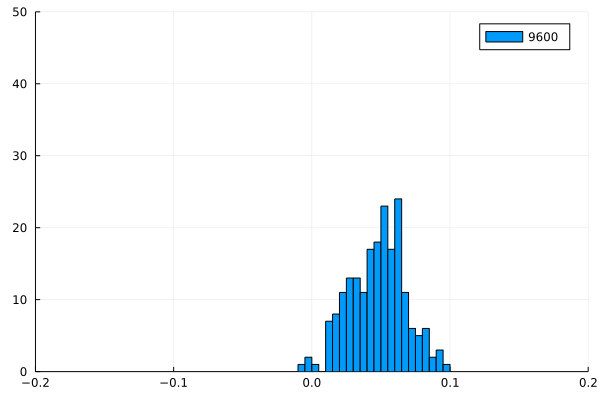

In [162]:
anim = @animate for i in 9600:10000
    histogram(z[i, :], bins = 40, label = "$i", xlims = (-0.2, 0.2), ylims = (0, 50), normalize = true)
end 
gif(anim, "BirkhoffAverages.gif", fps = 5)

In [163]:
v = orbit_with_noise(h, rand(Float64, 200), 0.3, 10000)

10000×200 Matrix{Float64}:
  0.20993     0.915511    0.845167   …   0.695981    0.0795197   0.932906
 -0.888076    0.24942    -0.0772378     -0.568412    0.754129    0.374688
 -0.0685907   0.980299   -0.820709       0.933532   -0.458985   -0.98017
  0.958175    0.68422     0.0392874      0.189442    0.917976   -0.934841
  0.328735   -0.747095    0.955005       0.703366    0.562178    0.553602
  0.960277   -0.26446     0.311983   …  -0.859892   -0.606126   -0.905165
  0.41514     0.84233     0.981134       0.0636173  -0.99741     0.268927
  0.899134   -0.0231933   0.718411      -0.825816   -0.791252   -0.895587
  0.0112374   0.910503   -0.753953      -0.447064   -0.594077    0.443638
  0.797859    0.0409642  -0.807891      -0.99916    -0.669705   -0.83054
 -0.311332    0.896658   -0.285751   …   0.908493   -0.53614    -0.429209
 -0.843749    0.432055    0.719466       0.0675783   0.878631    0.876307
 -0.314421   -0.751418   -0.734036      -0.849357    0.155299    0.2741
  ⋮            

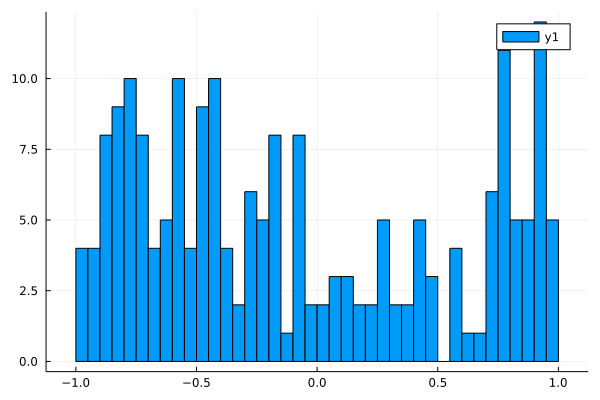

In [164]:
histogram(v[end, :], bins = 40)

In [166]:
z = BirkhoffAverages(ϕ, v)

10000×200 Matrix{Float64}:
 -3.94133    1.94949     1.6297    …   0.852854  -7.82442     2.02478
 -1.05677   -0.651194   -3.15559       0.447902  -3.3253      0.200358
 -3.50978    0.306869   -1.59965       0.974423  -2.48765     0.874395
 -2.09942    0.426322   -3.86094      -0.357208  -1.37568     1.16406
 -2.10902    0.568324   -2.66507      -0.106752  -1.10077     0.918721
 -1.40077   -0.0293426  -2.61366   …   0.194172  -0.867326    1.08294
 -1.37409    0.205742   -1.92222      -1.07884   -0.415963    0.506709
 -0.967665  -1.4141     -1.55948      -0.751851  -0.193214    0.676055
 -2.5992    -1.0428     -1.25588      -0.770271  -0.147346    0.49556
 -2.19935   -1.98629    -0.985368     -0.463321  -0.0627204   0.601991
 -2.21441   -1.63606    -1.14197   …  -0.246772  -0.0743688   0.449022
 -1.89462   -1.58757    -0.964669     -0.932482   0.0805805   0.559473
 -1.92777   -1.37626    -0.808479     -0.733869  -0.321544    0.295324
  ⋮                                ⋱                  

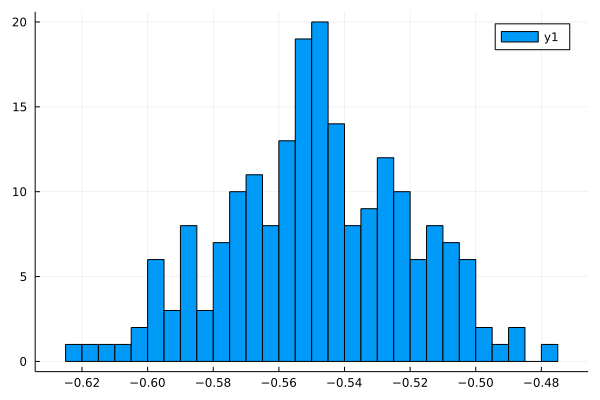

In [167]:
histogram(z[end, :], bins = 40)

# Final comments

In this notebook we saw many non-rigorous tools to investigate dynamical systems with Julia. We used histograms to see how orbits distribute in the interval $[0, 1]$ under the action of the dynamics.

We showed how to compute orbits, how to approximate the Birkhoff averages of observables and how to approximate an important quantity, the Lyapunov exponent (associated to the Physical measure).

We showed how this can be computed with various methods and different precisions, but all of these methods do not study the true dynamics, but a floating point approximation of it.
To show this, I will show one last example.

In [194]:
doubling(x) = mod(2*x, 1)

doubling (generic function with 1 method)

In [195]:
v = orbit(doubling, Float64(π)/4, 50)

50-element Vector{Float64}:
 0.7853981633974483
 0.5707963267948966
 0.14159265358979312
 0.28318530717958623
 0.5663706143591725
 0.13274122871834493
 0.26548245743668986
 0.5309649148733797
 0.061929829746759424
 0.12385965949351885
 0.2477193189870377
 0.4954386379740754
 0.9908772759481508
 ⋮
 0.352294921875
 0.70458984375
 0.4091796875
 0.818359375
 0.63671875
 0.2734375
 0.546875
 0.09375
 0.1875
 0.375
 0.75
 0.5

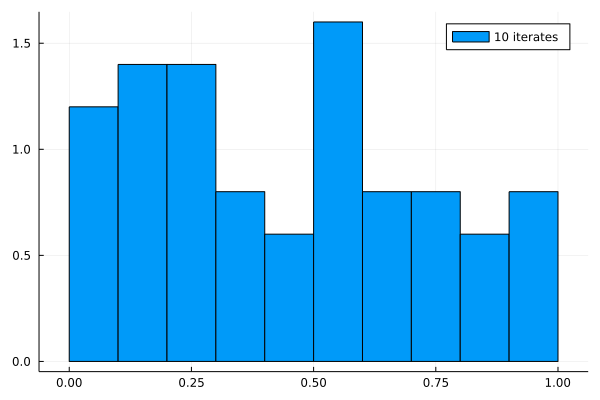

In [196]:
histogram(v, bins = 10, normalize = true, label = "10 iterates")

In [197]:
v = orbit(doubling, Float64(π)/4, 500)

500-element Vector{Float64}:
 0.7853981633974483
 0.5707963267948966
 0.14159265358979312
 0.28318530717958623
 0.5663706143591725
 0.13274122871834493
 0.26548245743668986
 0.5309649148733797
 0.061929829746759424
 0.12385965949351885
 0.2477193189870377
 0.4954386379740754
 0.9908772759481508
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

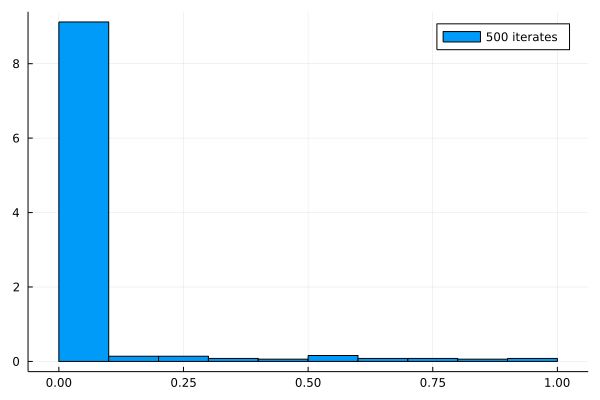

In [198]:
histogram(v, bins = 10, normalize = true, label = "500 iterates")

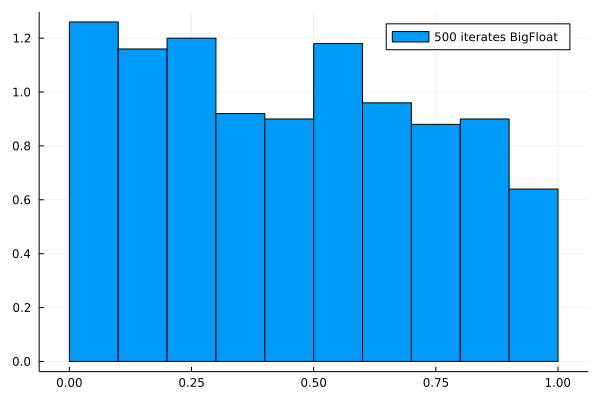

In [199]:
setprecision(1024)
v = orbit(doubling, BigFloat(π)/4, 500);
histogram(v, bins = 10, normalize = true, label = "500 iterates BigFloat")

The issue is that the computer represents numbers in base $2$ and the map $2x\, mod\, 1$ acts as a shift in base $2$; due to the fact that the the computer is a finite machine and pads with $0$, for any floating point number all the orbits converge to $0$ in a number of iterates equal to the precision. 

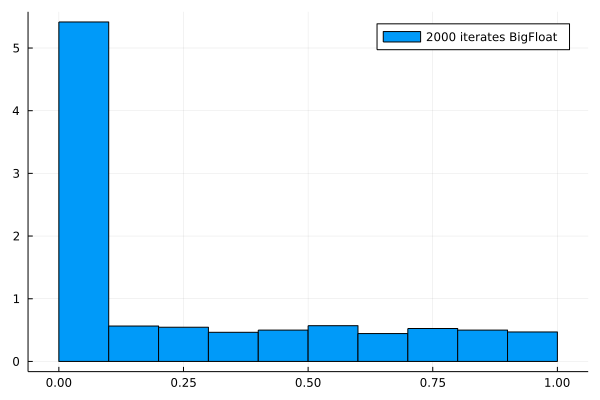

In [200]:
setprecision(1024)
v = orbit(doubling, BigFloat(π)/4, 2000);
histogram(v, bins = 10, normalize = true, label = "2000 iterates BigFloat")

The number $\pi/4$ has infinite binary expansion, and a mathematical analysis of the orbit of $\pi/4$ under the action of the dynamics shows that it does not land on $0$ but its binary representation does.
In general, since we have only a finite number of floating point numbers, for any dynamics $f$ its floating point representation has only preperiodic orbits (by Pidgeon Hole Principle). 


This is a strong motivation for looking for other tools to understand the statistichal behaviour of a dynamical system, through the use of tools from Functional Analysis.

I will present them in the next days, starting tomorrow from Interval Arithmetics, a tool that allows us to do Validated numerical computations.